# lampe testing

In [1]:
%load_ext autoreload
%autoreload 2

# ignore warnings for readability
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import torch
import torch.nn as nn

import ili
from ili.dataloaders import NumpyLoader
from ili.inference import InferenceRunner, LampeRunner
from ili.validation.metrics import PosteriorCoverage, PlotSinglePosterior

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device:', device)

Device: cpu


## Toy SNPE
This example attempts to infer 3 unknown parameters from a 20-dimensional 1D data vector using amortized posterior inference. We train the models from a simple synthetic catalog. This tutorial mirrors the same configuration as in [examples/toy_sbi.py](../examples/toy_sbi.py), but demonstrates how one would interact with the inference pipeline in a jupyter notebook.

In [21]:
# create synthetic catalog
def simulator(params):
    # create toy simulations
    x = np.arange(10)
    y = 3 * params[0] * np.sin(x) + params[1] * x ** 2 - 2 * params[2] * x
    y += np.random.randn(len(x))
    return y

seed_sim = 16188
np.random.seed(seed_sim)
theta = np.random.rand(500, 3)  # 200 simulations, 3 parameters
x = np.array([simulator(t) for t in theta])

# make a dataloader
loader = NumpyLoader(x=x, theta=theta)

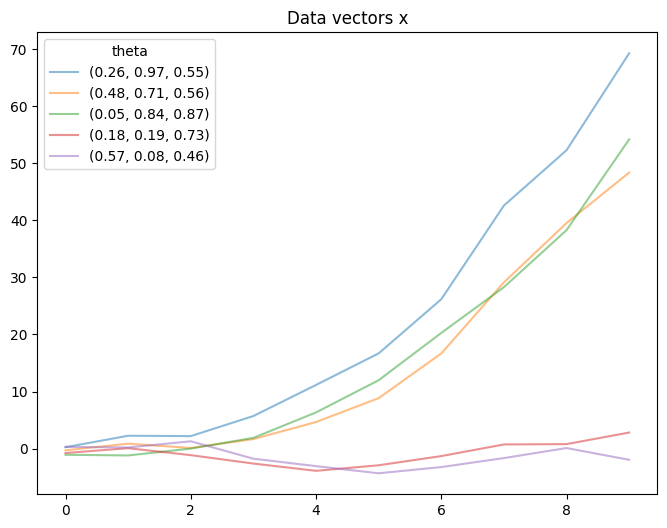

In [22]:
# plot some examples of the data
fig, ax = plt.subplots(figsize=(8, 6))
for i in range(5):
    ind = np.random.randint(len(theta))
    ax.plot(x[ind], alpha=0.5, label=f'(%.2f, %.2f, %.2f)' % tuple(theta[ind]))
ax.legend(title='theta')
ax.set_title('Data vectors x')
plt.show()

In [23]:
# define a prior
prior = ili.utils.Uniform(low=[0, 0, 0], high=[1, 1, 1], device=device)

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_lampe(model='maf', hidden_features=50, num_transforms=5),
    ili.utils.load_nde_lampe(model='mdn', hidden_features=50, num_components=6)
]

# define training arguments
train_args = {
    'training_batch_size': 16,
    'learning_rate': 2e-5,
    'stop_after_epochs': 30,
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='lampe',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    embedding_net=None,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [24]:
# train the model
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 2.
380 epochs [00:05, 74.70 epochs/s, loss=3.65, loss_val=5.38]
INFO:root:Training model 2 / 2.
340 epochs [00:03, 99.19 epochs/s, loss=4.94, loss_val=6.45] 
INFO:root:It took 8.523009061813354 seconds to train models.


Here, the output of the runner is a posterior model and a log of training statistics. The posterior model is a [NeuralPosteriorEnsemble](https://github.com/mackelab/sbi/blob/6c4fa7a6fd254d48d0c18640c832f2d80ab2257a/sbi/utils/posterior_ensemble.py#L19) model and automatically combines samples and probability densities from its component networks.

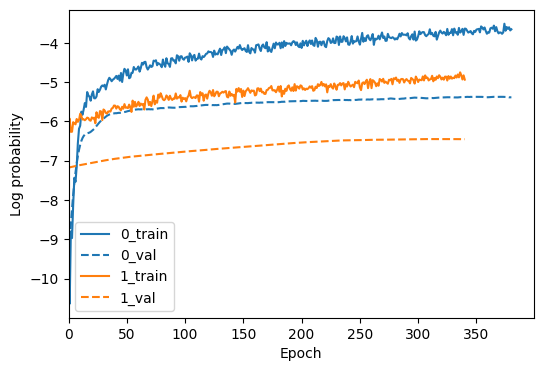

In [25]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [26]:
# Now, LampeRunner returns a custom class instance to be able to pass signature strings
# This class has simply for attributes a NeuralPosteriorEstimate and a string list 
print(posterior_ensemble.signatures)

# choose a random input
seed_in = None
np.random.seed(seed_in)
ind = np.random.randint(len(theta))

# generate samples from the posterior using accept/reject sampling
seed_samp = 2356
torch.manual_seed(seed_samp)
samples = posterior_ensemble.sample((1000,), torch.Tensor(x[ind]).to(device))

# calculate the log_prob for each sample
log_prob = posterior_ensemble.log_prob(samples, torch.Tensor(x[ind]).to(device))

samples = samples.cpu().numpy()
log_prob = log_prob.cpu().numpy()

INFO:root:Sampling models with [746 254] samples each.


['', '']


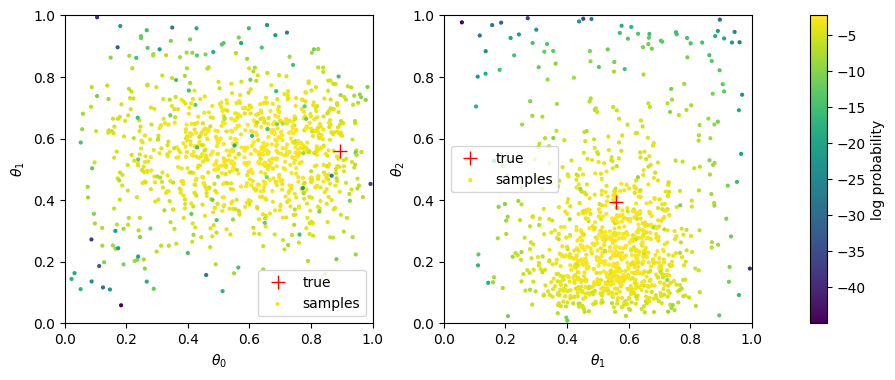

In [27]:
# plot the posterior samples and the true value
fig, axs = plt.subplots(1, 3, figsize=(10,4), gridspec_kw={'width_ratios': [1,1,0.05]})
for i in range(2):
    axs[i].plot(theta[ind,i], theta[ind,i+1], 'r+', markersize=10, label='true')
    im = axs[i].scatter(samples[:,i], samples[:,i+1], c=log_prob, s=4, label='samples')
    axs[i].set_aspect('equal')
    axs[i].set_xlim(0,1)
    axs[i].set_ylim(0,1)
    axs[i].set_xlabel(f'$\\theta_{i}$')
    axs[i].set_ylabel(f'$\\theta_{i+1}$')
    axs[i].legend()
plt.colorbar(im, label='log probability', use_gridspec=True, cax=axs[2])

INFO:root:Sampling models with [746 254] samples each.


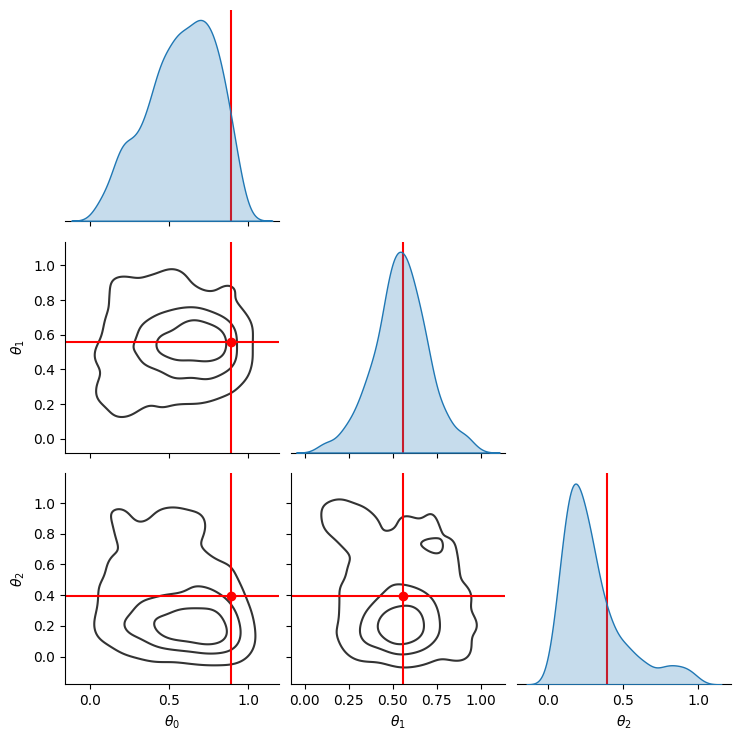

In [28]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    labels=[f'$\\theta_{i}$' for i in range(3)]
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = x[ind], theta_fid=theta[ind]
)

### Using the ensemble of trained posteriors models
By default, running a SampleBasedMEtric with posterior from above will compute the metrics using the ensemble model. That is to say the ensemble is considered one model, with the weights of each posterior in the ensemble being the val_log_prob.

100%|██████████| 500/500 [00:01<00:00, 298.24it/s]
INFO:root:Mean logprob: 1.0408e+00Median logprob: 1.2271e+00
100%|██████████| 100/100 [00:01<00:00, 82.22it/s]
INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


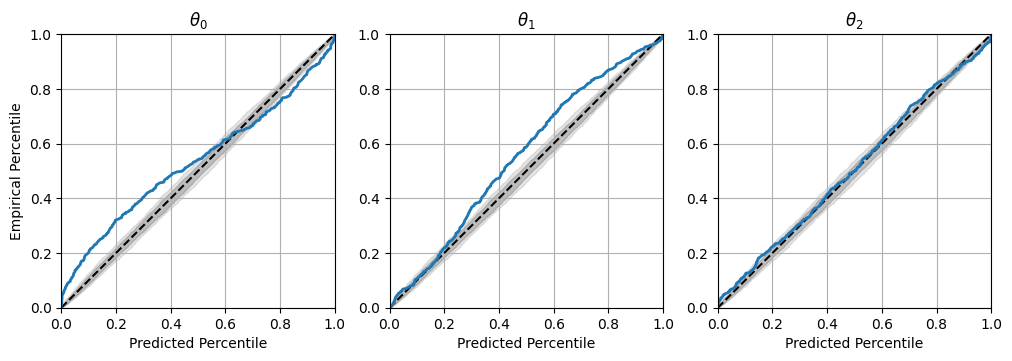

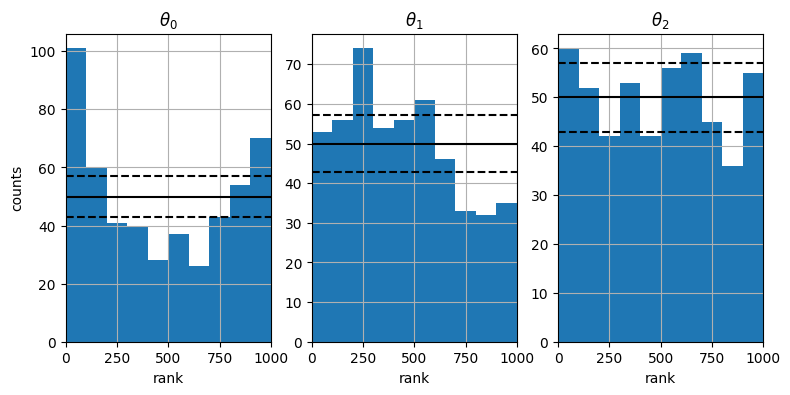

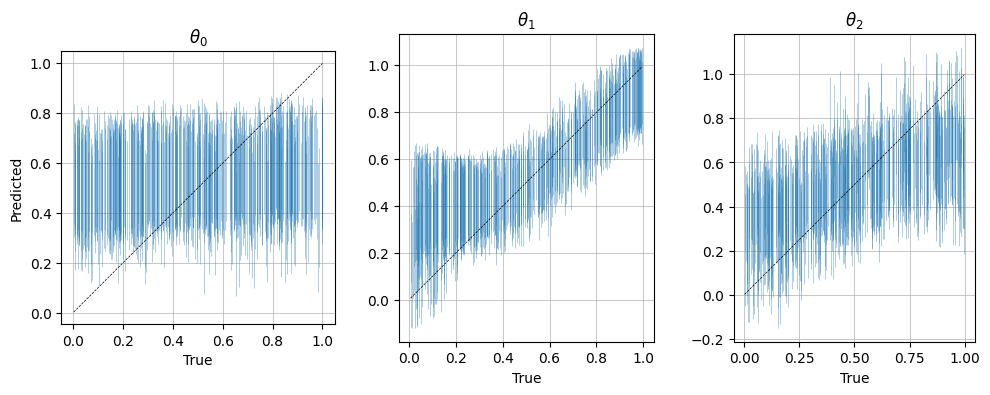

INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


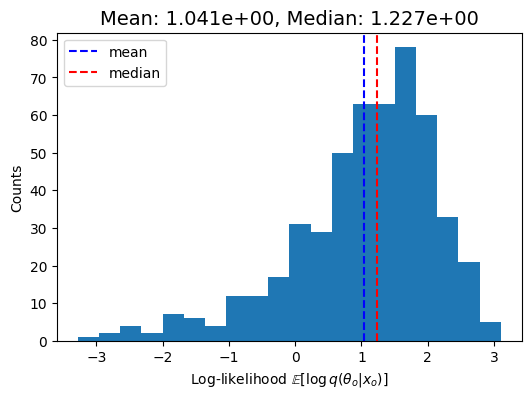

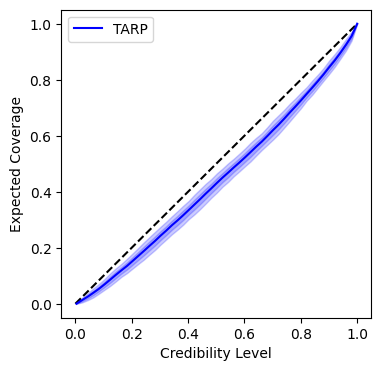

In [29]:
# Drawing samples from the ensemble posterior

metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct', 
    labels=[f'$\\theta_{i}$' for i in range(3)],
    plot_list = ["coverage", "histogram", "predictions", "tarp"],
    out_dir=None
)

fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x=x, theta=theta
)

In the ensemble model, it looks like our posteriors are well-calibrated when evaluated on marginal distributions, but slightly negatively biased in the multivariate TARP coverage.

### Evaluating each trained posterior in the ensemble
Below, we compute separately each SampleBasedMetric for every posterior in the ensemble.

  0%|          | 0/500 [00:00<?, ?it/s]

100%|██████████| 500/500 [00:01<00:00, 292.22it/s]
INFO:root:Mean logprob: -2.7884e+00Median logprob: 1.3651e+00
100%|██████████| 100/100 [00:01<00:00, 84.02it/s]
INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


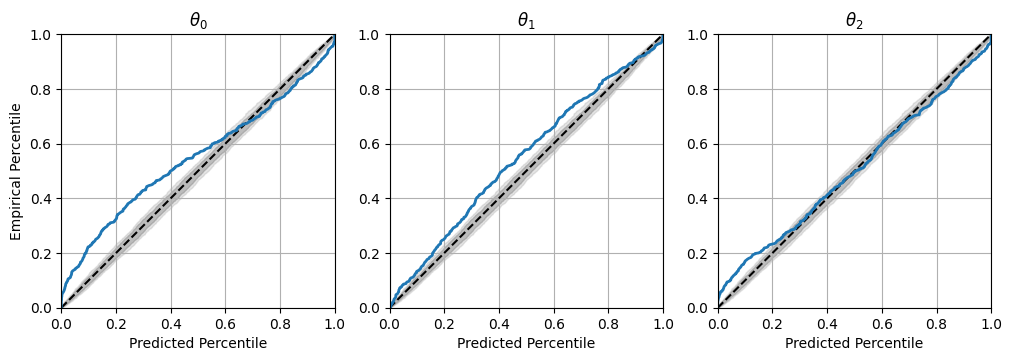

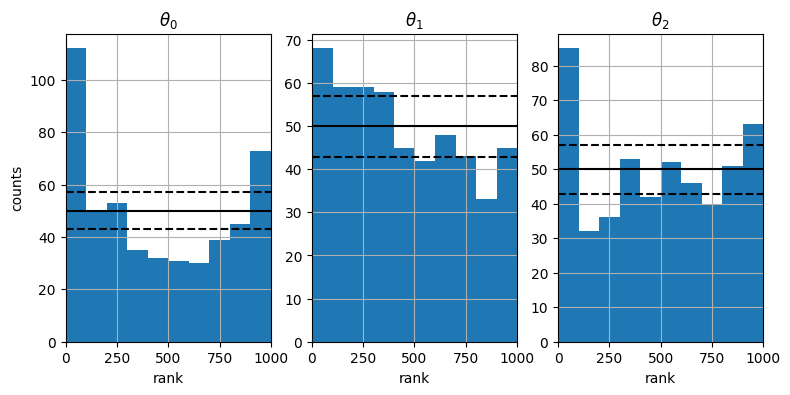

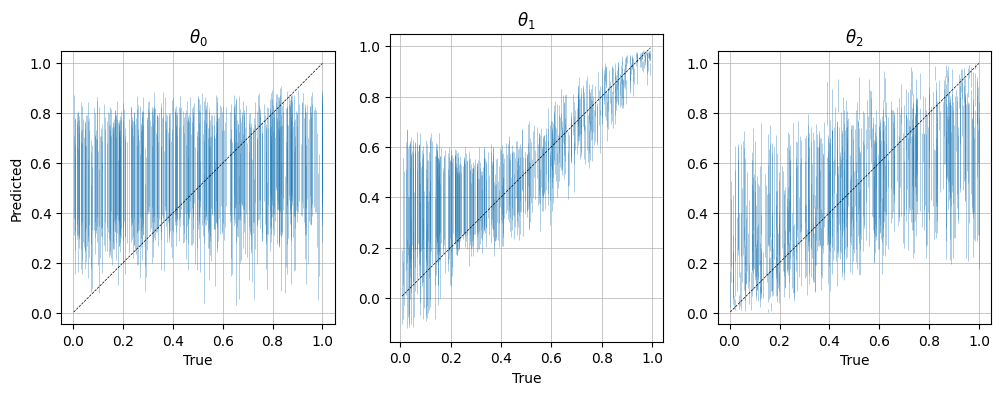

INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


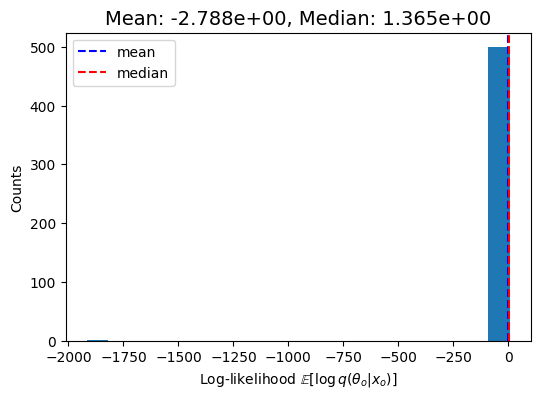

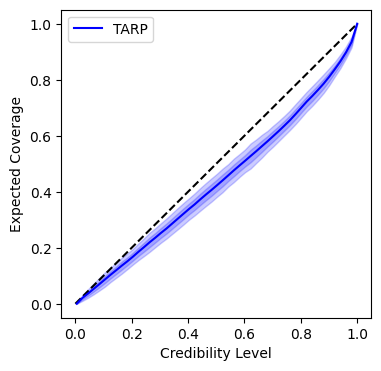

In [30]:
# Drawing samples for each posterior in the ensemble
# First the MAF posterior
metric = PosteriorCoverage(num_samples=1000, 
    sample_method='direct', labels=[f'$\\theta_{i}$' for i in range(3)],
    plot_list = ["coverage", "histogram", "predictions", "tarp"])

fig = metric(
    posterior=posterior_ensemble.posteriors[0],
    x=x, theta=theta
)

100%|██████████| 500/500 [00:00<00:00, 1498.58it/s]
INFO:root:Mean logprob: -1.8507e-01Median logprob: 8.2803e-02
100%|██████████| 100/100 [00:01<00:00, 83.84it/s]
INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


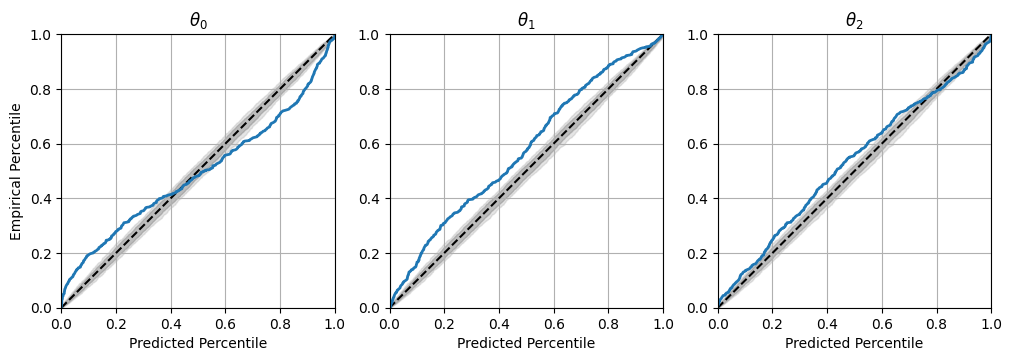

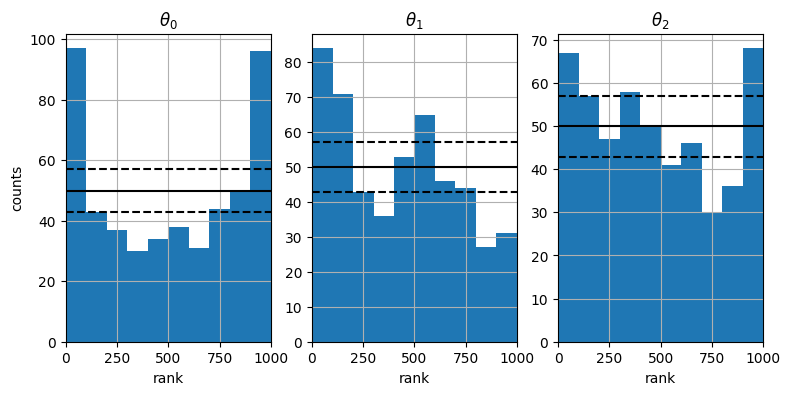

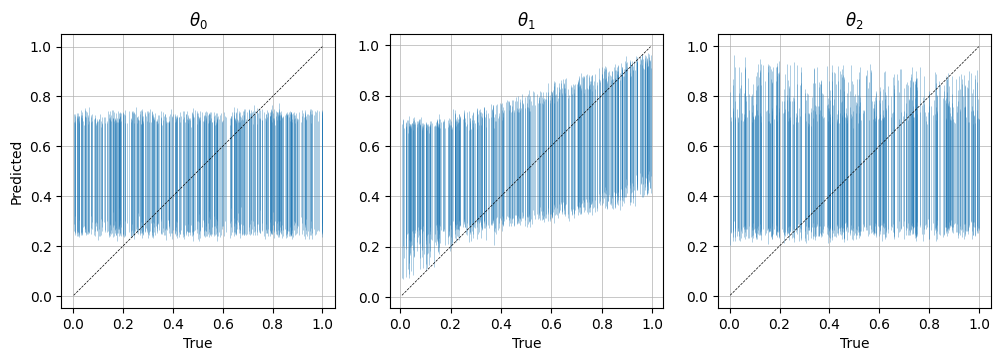

INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


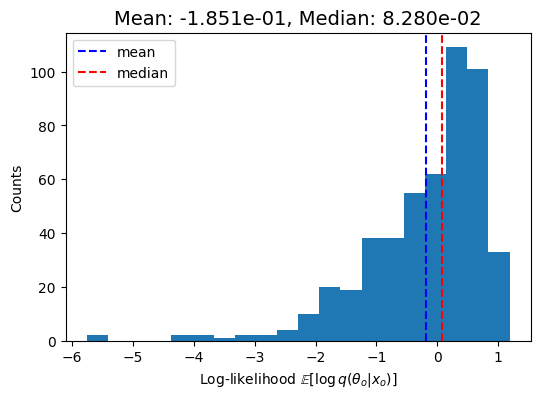

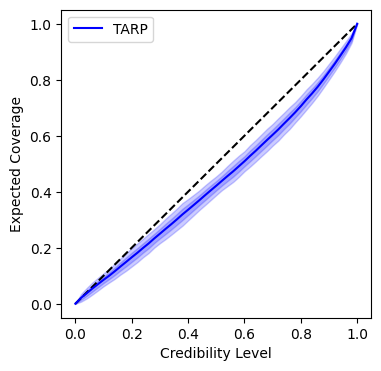

In [31]:
# Then for the MDN
fig = metric(
    posterior=posterior_ensemble.posteriors[1], # NeuralPosteriorEnsemble instance from sbi package
    x_obs = x[ind], theta_fid=theta[ind],
    x=x, theta=theta
)

# Graph example

In [32]:
import numpy as np
import torch_geometric as pyg

In [33]:
# Using the QM7b dataset from pytorch geometric
# Ref: https://arxiv.org/abs/1703.00564

data = pyg.datasets.QM7b(root='./toy')
x = data
theta = data.y

# Let's only look at the first 5 dimensions
dim_theta = 5
theta = theta[:,:dim_theta]

tensor([-1.5089e+03,  8.1991e+00,  2.2317e-01, -9.3640e+00,  9.3800e-01])


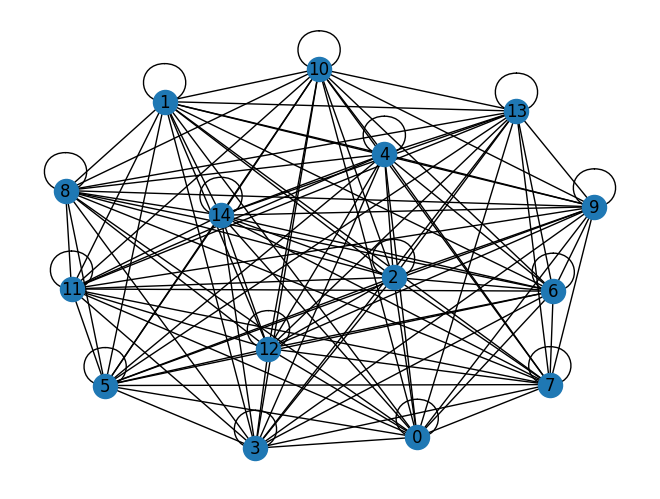

In [34]:
import networkx as nx

# plot an example
i = np.random.randint(len(data))
x_, y_ = x[i], theta[i]
g = pyg.utils.to_networkx(x_, to_undirected=True)
nx.draw(g, with_labels=True)
print(y_)

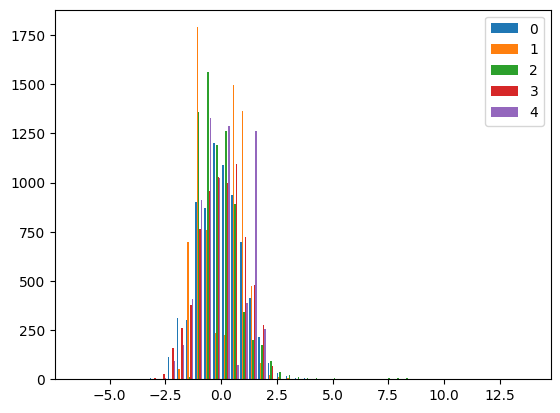

In [35]:
# Normalize the y's

ymu = theta.numpy().mean(axis=0).reshape(1,-1)
ystd = theta.numpy().std(axis=0).reshape(1,-1)

plt.hist(((theta - ymu)/ystd).T, bins=50, label=range(dim_theta))
plt.legend();

In [36]:
from torch.utils.data import DataLoader
from ili.dataloaders import TorchLoader
from torch_geometric.loader.dataloader import Collater

# use pyg's collater
collater = Collater(data)

# output (input, output) pairs
def collate_fn(batch):
    batch = collater(batch)
    return batch, (batch.y[:,:dim_theta]-ymu)/ystd

# train/val split
mask = np.random.rand(len(data)) < 0.9
train_data = data[mask]
val_data = data[~mask]

train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False, collate_fn=collate_fn)

# define an ili loader
loader = TorchLoader(train_loader, val_loader)
    

In [37]:
# Design a Graph Attention Network embedder

import torch
from torch_geometric import nn as gnn
from torch_geometric.nn import aggr
from torch import nn
import torch.nn.functional as F

class GATNetwork(nn.Module):
    def __init__(
        self, in_channels, gcn_channels, gcn_heads,
        dense_channels, out_channels, drop_p=0.1,
        edge_dim=None
    ):
        super().__init__()
        self.in_channels = in_channels
        self.dense_channels = dense_channels
        self.out_channels = out_channels
        self.drop_p = drop_p
        self.edge_dim = edge_dim
        self.gcn_channels = gcn_channels
        self.gcn_heads = gcn_heads

        self.graph_aggr = aggr.MultiAggregation(
            aggrs=['sum', 'mean', 'std', 'min',
                   'max', aggr.SoftmaxAggregation(learn=True)],
            mode='cat'
        )
        self.dropout = torch.nn.Dropout(p=self.drop_p)

        self._build_gnn()
        self._build_dnn(gcn_channels[-1]*len(self.graph_aggr.aggrs))
        
    def _build_dnn(self, in_channels):
        self.fc1 = torch.nn.Linear(in_channels, self.dense_channels[0])
        self.fcs = torch.nn.ModuleList(
            [torch.nn.Linear(self.dense_channels[i], self.dense_channels[i+1])
             for i in range(0, len(self.dense_channels)-1)])
        self.fc2 = torch.nn.Linear(self.dense_channels[-1], self.out_channels)

    def dnn(self, x):
        x = F.relu(self.fc1(x))
        for fc in self.fcs:
            x = self.dropout(x)
            x = F.relu(fc(x))
        x = self.fc2(x)
        return x
    
    def _build_gnn(self):
        self.conv1 = gnn.GATv2Conv(
            self.in_channels, self.gcn_channels[0], 
            heads=self.gcn_heads[0], edge_dim=self.edge_dim)
        self.convs = torch.nn.ModuleList(
            [gnn.GATv2Conv(self.gcn_channels[i]*self.gcn_heads[i],
                           self.gcn_channels[i+1], heads=self.gcn_heads[i+1],
                           edge_dim=self.edge_dim)
             for i in range(len(self.gcn_channels)-2)]
        )
        self.conv2 = gnn.GATv2Conv(
            self.gcn_channels[-2]*self.gcn_heads[-2],
            self.gcn_channels[-1], heads=self.gcn_heads[-1], 
            concat=False, edge_dim=self.edge_dim)

    def gnn(self, x, edge_index, edge_attr):
        x = F.relu(self.conv1(x, edge_index, edge_attr))
        # x = self.dropout(x)
        for conv in self.convs:
            x = F.relu(conv(x, edge_index, edge_attr))
            # x = self.dropout(x)
        x = self.conv2(x, edge_index, edge_attr)
        return x

    def forward(self, x):
        node_features = torch.ones(x.num_nodes, 1)
        edge_index, edge_attr = x.edge_index, x.edge_attr
        ptr = x.ptr if hasattr(x, 'ptr') else None

        x = self.gnn(x=node_features, edge_index=edge_index, edge_attr=edge_attr)
        x = self.graph_aggr(x, ptr=ptr)
        x = self.dnn(x)
        return x
    
model = GATNetwork(
    in_channels=1, gcn_channels=[4, 8], 
    gcn_heads=[4, 4],
    dense_channels=[32, 16], out_channels=6,
    edge_dim=1
)
model

GATNetwork(
  (graph_aggr): MultiAggregation([
    SumAggregation(),
    MeanAggregation(),
    StdAggregation(),
    MinAggregation(),
    MaxAggregation(),
    SoftmaxAggregation(learn=True),
  ], mode=cat)
  (dropout): Dropout(p=0.1, inplace=False)
  (conv1): GATv2Conv(1, 4, heads=4)
  (convs): ModuleList()
  (conv2): GATv2Conv(16, 8, heads=4)
  (fc1): Linear(in_features=48, out_features=32, bias=True)
  (fcs): ModuleList(
    (0): Linear(in_features=32, out_features=16, bias=True)
  )
  (fc2): Linear(in_features=16, out_features=6, bias=True)
)

In [38]:
# define a prior
prior = ili.utils.IndependentNormal(loc=[0]*dim_theta, scale=[1]*dim_theta, device=device)

# instantiate your neural networks to be used as an ensemble
nets = [
    ili.utils.load_nde_lampe(model='maf', hidden_features=50, num_transforms=5, embedding_net=model),
    ili.utils.load_nde_lampe(model='mdn', hidden_features=50, num_components=6, embedding_net=model)
]

# define training arguments
train_args = {
    'training_batch_size': 64,
    'learning_rate': 2e-5,
    'stop_after_epochs': 30,
}

# initialize the trainer
runner = InferenceRunner.load(
    backend='lampe',
    engine='NPE',
    prior=prior,
    nets=nets,
    device=device,
    embedding_net=model,
    train_args=train_args,
    proposal=None,
    out_dir=None
)

In [39]:
# train the model
posterior_ensemble, summaries = runner(loader=loader)

INFO:root:MODEL INFERENCE CLASS: NPE
INFO:root:Training model 1 / 2.
81 epochs [02:52,  2.13s/ epochs, loss=4.35, loss_val=5.15]
INFO:root:Training model 2 / 2.
167 epochs [05:34,  2.00s/ epochs, loss=2.93, loss_val=3.74]
INFO:root:It took 507.2051329612732 seconds to train models.


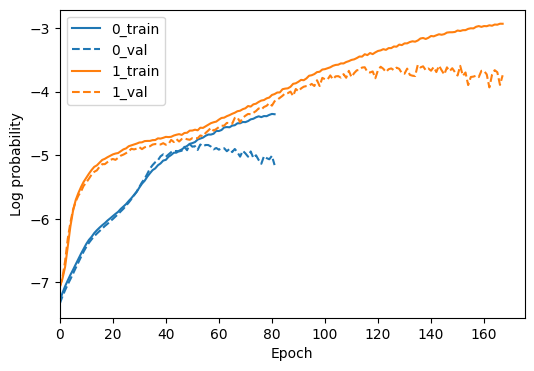

In [40]:
# plot train/validation loss
fig, ax = plt.subplots(1, 1, figsize=(6,4))
c = list(mcolors.TABLEAU_COLORS)
for i, m in enumerate(summaries):
    ax.plot(m['training_log_probs'], ls='-', label=f"{i}_train", c=c[i])
    ax.plot(m['validation_log_probs'], ls='--', label=f"{i}_val", c=c[i])
ax.set_xlim(0)
ax.set_xlabel('Epoch')
ax.set_ylabel('Log probability')
ax.legend()

In [41]:
# Now, LampeRunner returns a custom class instance to be able to pass signature strings
# This class has simply for attributes a NeuralPosteriorEstimate and a string list 
print(posterior_ensemble.signatures)

# choose a random input
seed_in = None
np.random.seed(seed_in)
ind = np.random.randint(len(data))
x_ = data[ind]
y_ = (data.y[ind, :dim_theta] - ymu[0])/ystd[0]

# generate samples from the posterior using accept/reject sampling
seed_samp = 1234
torch.manual_seed(seed_samp)
samples = posterior_ensemble.sample((1000,), data[ind])

# calculate the log_prob for each sample
log_prob = posterior_ensemble.log_prob(samples, data[ind])

samples = samples.cpu().numpy()
log_prob = log_prob.cpu().numpy()

INFO:root:Sampling models with [223 777] samples each.


['', '']


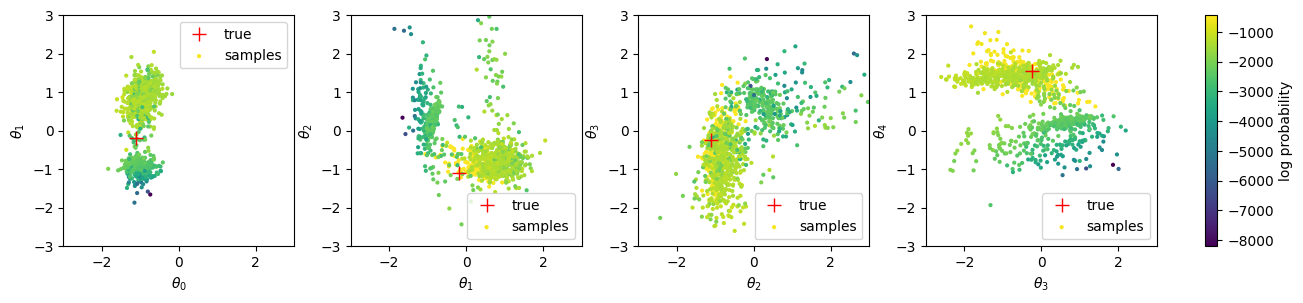

In [46]:
# plot the posterior samples and the true value
fig, axs = plt.subplots(1, dim_theta, figsize=(3*dim_theta,3), 
                        gridspec_kw={'width_ratios': [1]*(dim_theta-1)+[0.05]})
for i in range(dim_theta-1):
    axs[i].plot(y_[i], y_[i+1], 'r+', markersize=10, label='true')
    im = axs[i].scatter(samples[:,i], samples[:,i+1], c=log_prob, s=4, 
                        label='samples')
    axs[i].set_aspect('equal')
    axs[i].set_xlim(-3,3)
    axs[i].set_ylim(-3,3)
    axs[i].set_xlabel(f'$\\theta_{i}$')
    axs[i].set_ylabel(f'$\\theta_{i+1}$')
    axs[i].legend()
plt.colorbar(im, label='log probability', use_gridspec=True, cax=axs[-1])

INFO:root:Sampling models with [223 777] samples each.


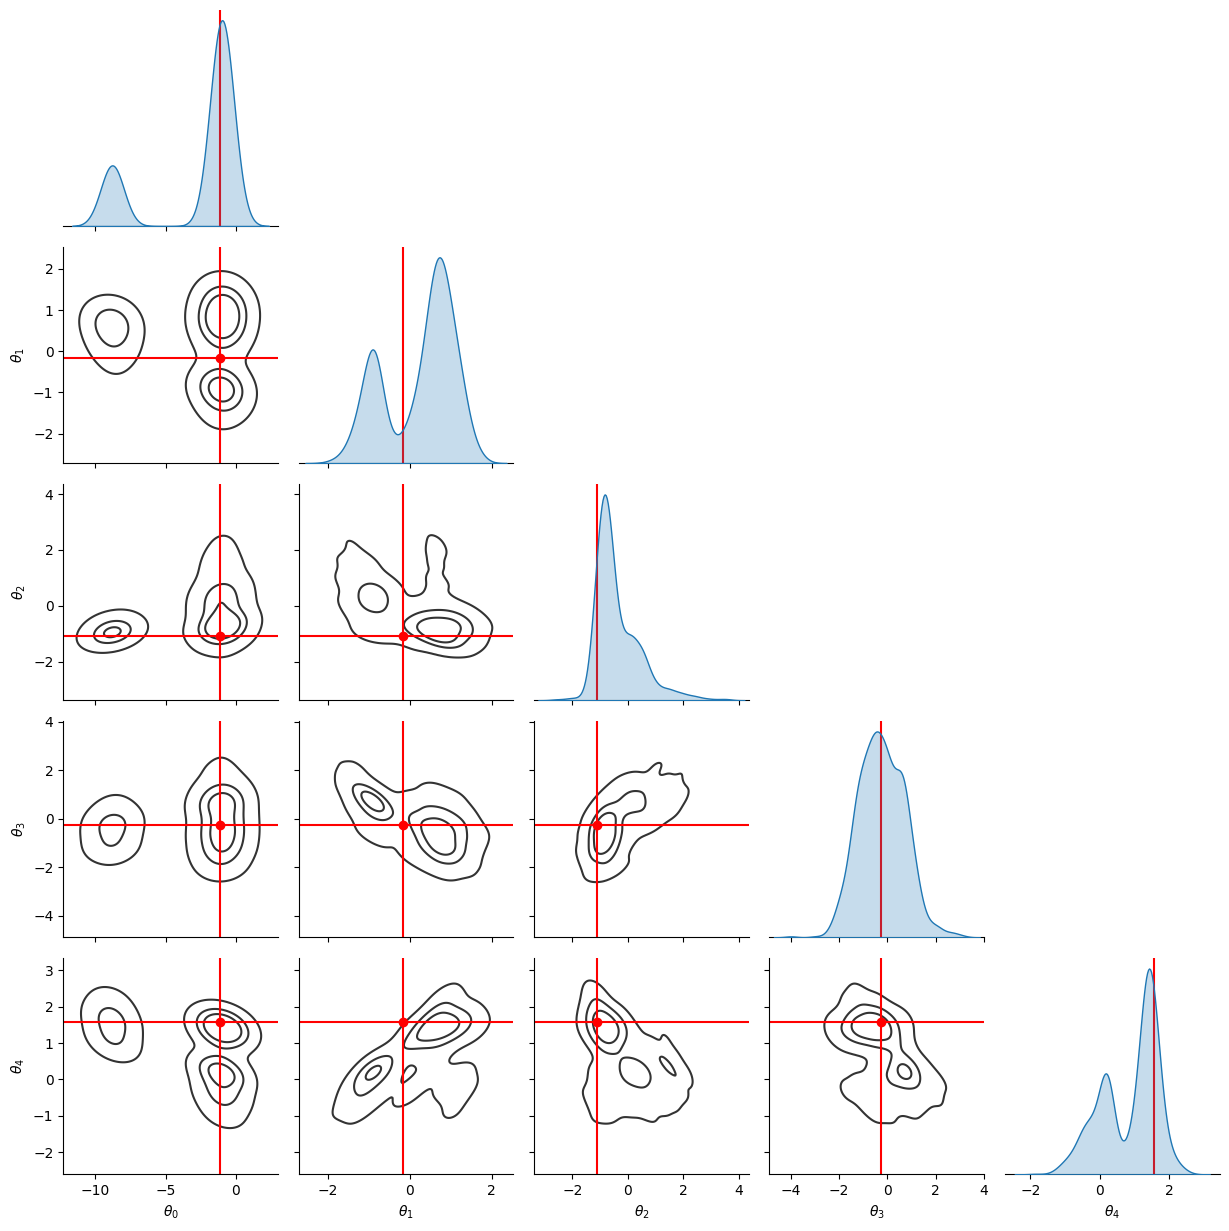

In [43]:
# use ltu-ili's built-in validation metrics to plot the posterior for this point
metric = PlotSinglePosterior(
    num_samples=1000, sample_method='direct', 
    labels=[f'$\\theta_{i}$' for i in range(dim_theta)]
)
fig = metric(
    posterior=posterior_ensemble,
    x_obs = x_, theta_fid=y_
)

100%|██████████| 7211/7211 [00:30<00:00, 234.18it/s]
INFO:root:Mean logprob: -5.2057e+00Median logprob: -4.8962e+00
100%|██████████| 100/100 [00:23<00:00,  4.26it/s]
INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


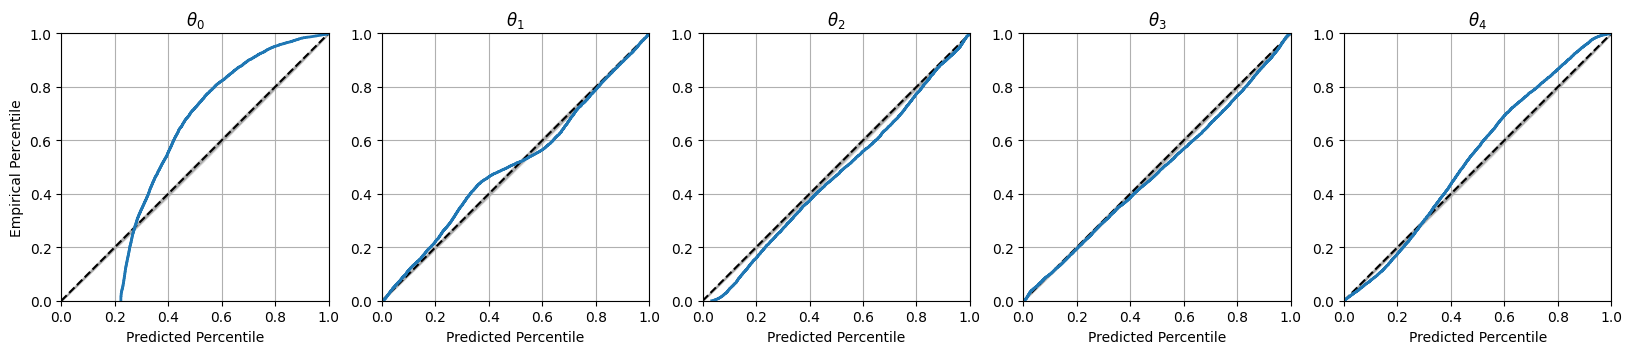

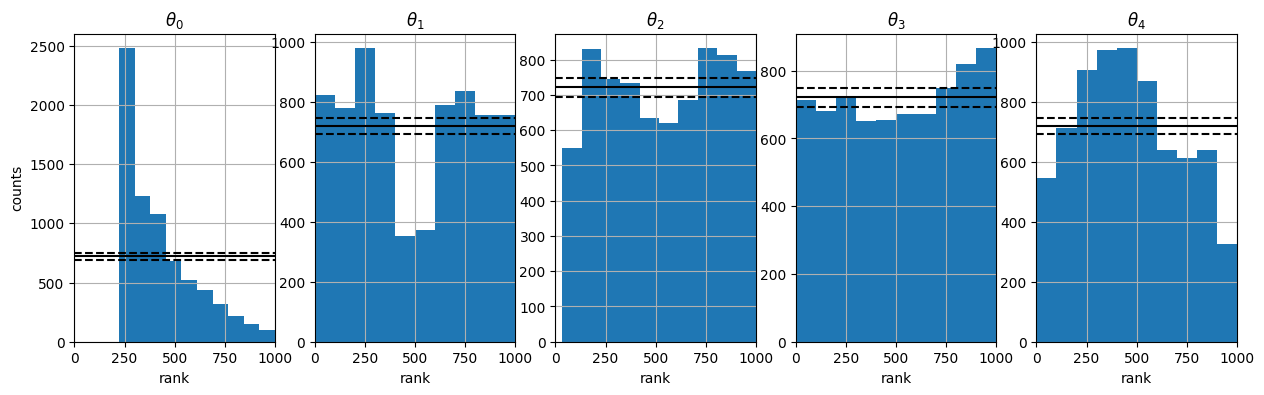

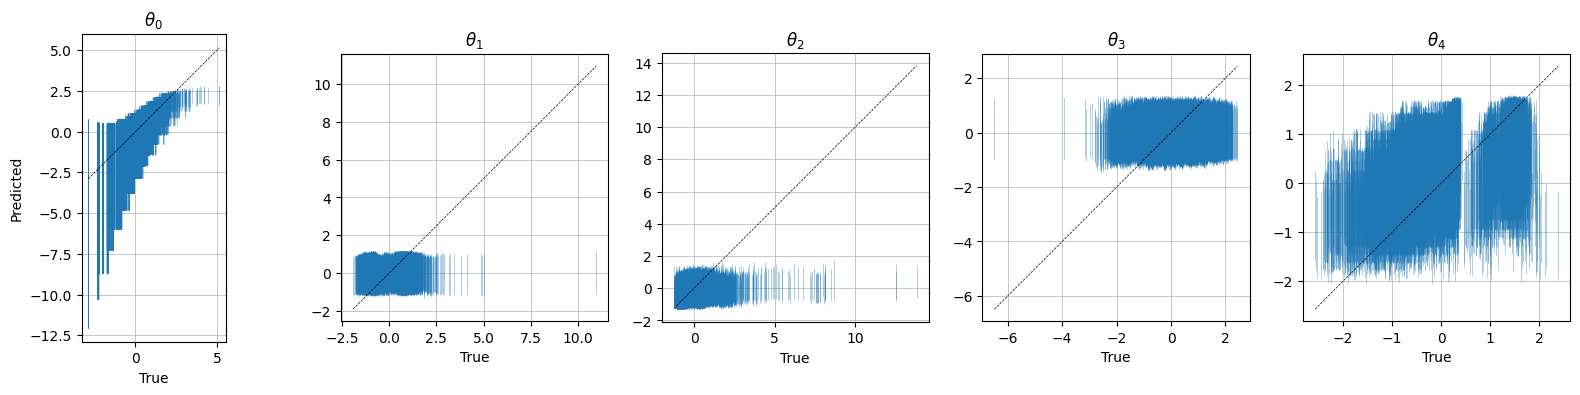

INFO:matplotlib.mathtext:Substituting symbol E from STIXNonUnicode


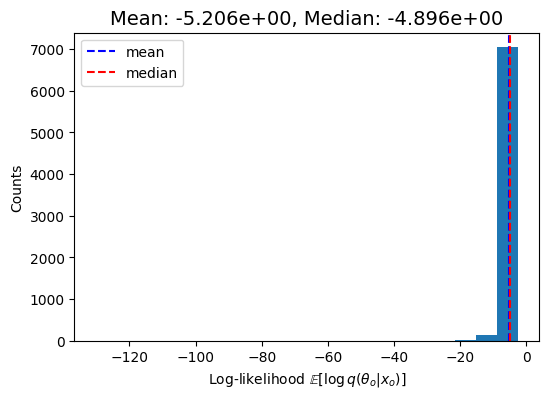

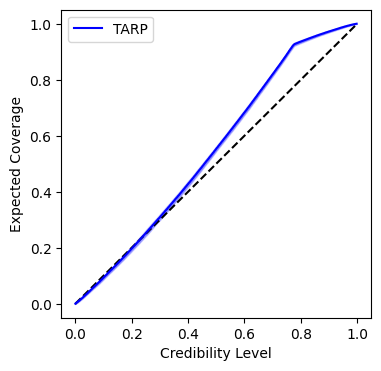

In [44]:
# Drawing samples from the ensemble posterior

metric = PosteriorCoverage(
    num_samples=1000, sample_method='direct', 
    labels=[f'$\\theta_{i}$' for i in range(dim_theta)],
    plot_list = ["coverage", "histogram", "predictions", "tarp"],
    out_dir=None
)

fig = metric(
    posterior=posterior_ensemble, # NeuralPosteriorEnsemble instance from sbi package
    x=x, theta=(theta-ymu)/ystd
)